In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 23j

##  Pytorch Convolutional Neural Network (CNN)
### CIFAR10

<img src='../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Changes-----------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# Changes-----------------------------------
from torch.utils.data import DataLoader, Dataset

from torchsummary import summary
from torchvision import transforms, datasets

%matplotlib inline

In [3]:
###----------------------
### Some basic parameters
###----------------------

import matplotlib.pyplot as plt
# Directories
inpDir = '../DNN/DNN_Sep2023/input/' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models'
subDir = 'flower_photos'
altName = 'cnn_base'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

# Number of cycles to run
EPOCHS = 100

TEST_SIZE = 0.2

# How many training examples to consider in one batch
BATCH_SIZE = 32 

# Image size for analysis
IMG_HEIGHT = 190
IMG_WIDTH = 190

# Patience before early stopping
PATIENCE = 20 
LR_FACTOR = 0.8
LR_PATIENCE = 10

# Learning Rate
ALPHA = 0.001

# Minimum difference
EPSILON = 1e-8

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,8),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams


# Path to final model and best weights
bestModelDict = os.path.join(modelDir, subDir, f'best_{altName}_param_dict')

bestModelPath =  os.path.join(modelDir, subDir, f'best_{altName}.pth')

In [4]:
# # Check if all directories are present
# if not os.path.exists(os.path.join(outDir)):
#     os.makedirs(os.path.join(outDir))
#     print ('Created {} directory'.format(outDir))

# if not os.path.exists(os.path.join(modelDir, subDir)):
#     os.makedirs(os.path.join(modelDir, subDir))
#     print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## All about CUDA

In [5]:
# print ('Is CUDA available: ', torch.cuda.is_available())

# print ('CUDA version: ', torch.version.cuda )

# print ('Current Device ID: ', torch.cuda.current_device())

# print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

# # Get cpu or gpu device for training.

# device = "cuda" if torch.cuda.is_available() else "cpu"

# print(f"Using {device} device")

## Helper Functions

In [6]:
# Function to display images imported through pytorch.

def fn_imshow(image, ax=None, title=None, normalize=True):
    
    '''
    Args:
        image: image with channel first and floats
        ax : Matplotlib axis,
        title: titile of the image
        normalize: If there is need to normalize the image
        
    Return: Matplotlib axis
    
    '''
    
    # if there is no axis, create one
    if ax is None:
        fig, ax = plt.subplots()
        
    # convert channel first to channel last
    image = image.numpy().transpose((1, 2, 0))

    # Do we want to normalize the image
    if normalize:
        
        mean = np.array([0.485, 0.456, 0.406])
        
        std = np.array([0.229, 0.224, 0.225])
        
        image = std * image + mean
        
        image = np.clip(image, 0, 1)
        
    # Show image on the axis
    ax.imshow(image)
    
    # Show classname on the image
    ax.set_title(title)
    
    # switch off all spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    
    # No tick labels
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [7]:
def fn_plot_hist(H):
    
    fig, axes = plt.subplots(1, 2 , figsize = ( 15, 6 ) ) 

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    hist_df = pd.DataFrame(H)
    hist_df['loss'] = hist_df['loss'].apply(pd.to_numeric)
    hist_df['test_loss'] = hist_df['test_loss'].apply(pd.to_numeric)
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]

    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left


    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

## Read Flowers Dataset

In [8]:
### Transformation

transform = transforms.Compose([
    transforms.Resize(IMG_HEIGHT),
    transforms.CenterCrop(IMG_HEIGHT),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

data_dir = os.path.join(inpDir,subDir)

dataset = datasets.ImageFolder(data_dir,transform=transform)

In [9]:
dataset

Dataset ImageFolder
    Number of datapoints: 3670
    Root location: ../DNN/DNN_Sep2023/input/flower_photos
    StandardTransform
Transform: Compose(
               Resize(size=190, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(190, 190))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [10]:
os.listdir(data_dir)

['sunflowers', 'LICENSE.txt', 'tulips', 'dandelion', 'roses', 'daisy']

In [11]:
image,label = next(iter(dataset))
image.shape,label

(torch.Size([3, 190, 190]), 0)

In [12]:
dataset_size = len(dataset)
test_size = int(TEST_SIZE*dataset_size)
print(dataset_size,test_size)

3670 734


In [13]:
indices = torch.randperm(len(dataset)).tolist()

#Pick up the indices upto test size
train_dataset = torch.utils.data.Subset(dataset,indices[:-test_size])

#Pick up from test
test_dataset = torch.utils.data.Subset(dataset,indices[-test_size:])

In [14]:
class_names = train_dataset.dataset.classes
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [15]:
numClasses = len(class_names)

In [16]:
next(iter(train_dataset))[0].shape

torch.Size([3, 190, 190])

## Data Loader

In [17]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

trainSteps = len(train_dataloader.dataset)//BATCH_SIZE

testSteps = len(test_dataloader.dataset)//BATCH_SIZE

print(trainSteps,testSteps)

91 22


In [18]:
def fn_showImages(img, ax):
    
    img = img.numpy().transpose((1,2,0))
    
    means=np.array([0.485,0.456,0.406])
    stds=np.array([0.229,0.224,0.225])
    img = stds*img + means
    img = np.clip(img,0,1)
    ax.imshow(img)

torch.Size([32, 3, 190, 190]) torch.Size([32])


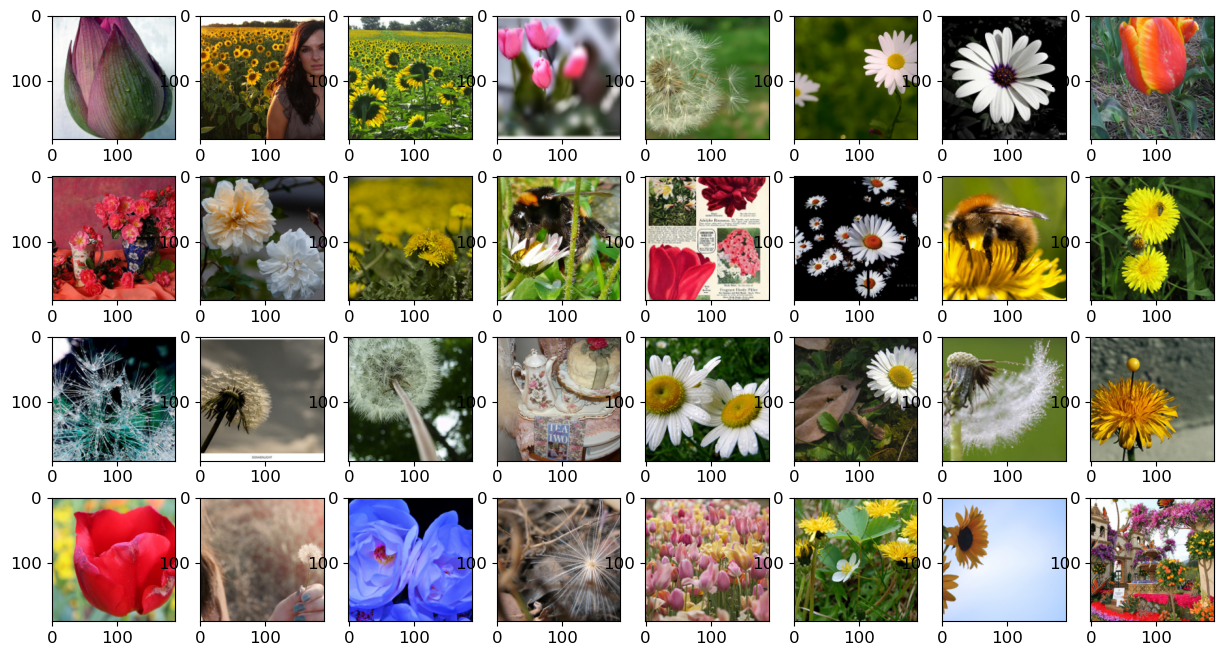

In [19]:
images,labels = next(iter(train_dataloader))
print(images.shape,labels.shape)

fig = plt.figure(figsize=(15,8))

for i in range (BATCH_SIZE):
    ax = fig.add_subplot(BATCH_SIZE//8,8,i+1)
    fn_showImages(images[i],ax)

In [20]:
outChannels1 = 64
outChannels2 = 128
outChannels3 = 256
outChannels4 = 512
outChannels5 = 512
outChannels6 = 1024
NumChannels = 3  ### Hard Coded R x G x B  # maybe 3 is input dont know 

model = nn.Sequential(
    
    #--------------------------------------- Set1 ----------------------------------------
    # Conv2D --> ReLU --> MaxPool2D
    
    nn.Conv2d(in_channels=NumChannels,
              out_channels=outChannels1,
              kernel_size=(3,3),
              padding='same'), # 188 X 188 X 64
    
    nn.ReLU(),
    
    nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)), # 94 x 94 x 64 
    
    
    #--------------------------------------- Set2 ----------------------------------------
    # Conv2D --> ReLU --> MaxPool2D
    
    nn.Conv2d(in_channels=outChannels1,
              out_channels=outChannels2,
              kernel_size=(3,3)), # 92 X 92 X 128
    
    nn.ReLU(),
    
    nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)), # 46 x 46 x 128 
    
    
    #--------------------------------------- Set3 ----------------------------------------
    # Conv2D --> ReLU --> MaxPool2D
    
    nn.Conv2d(in_channels=outChannels2,
              out_channels=outChannels3,
              kernel_size=(3,3)), # 44 X 44 X 256
    
    nn.ReLU(),
    
    nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)), # 22 x 22 x 256 
    
    
    #--------------------------------------- Set4 ----------------------------------------
    # Conv2D --> ReLU --> MaxPool2D
    
    nn.Conv2d(in_channels=outChannels3,
              out_channels=outChannels4,
              kernel_size=(3,3)), # 20 X 20 X 512
    #nn.BatchNorm2d(outChannels4)
    nn.ReLU(),
    #nn.Dropout(drop_out_rate)
    nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)), # 10 x 10 x 512 
    
    
    #--------------------------------------- Set5 ----------------------------------------
    # Conv2D --> ReLU --> MaxPool2D
    
    nn.Conv2d(in_channels=outChannels4,
              out_channels=outChannels5,
              kernel_size=(3,3)), # 8 X 8 X 512
    
    nn.ReLU(),
    
    nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)), # 4 x 4 x 512 
    
    
    #----------------------------------------- Set6 ---------------------------------------
    
     nn.Conv2d(in_channels=outChannels5,
              out_channels=outChannels6,
              kernel_size=(3,3)), # 2 X 2 X 1024
    
    nn.ReLU(),
    
     # ----------------------------------- ANN Layer  ------------------------------------------
    
    nn.Flatten(),
    
    nn.Linear(in_features=2*2*outChannels6,out_features=outChannels6),
    
    nn.ReLU(),
    
    nn.Linear(in_features=outChannels6,out_features=numClasses),
# rflrl
    
 )

#self.layer1 = nn.

In [21]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (16): ReLU()
  (17): Flatten(start_dim=1, end_dim=-1)
  (18): Linear(in_features=4096

In [22]:
loss_fn=nn.CrossEntropyLoss()
train_loss, test_loss=[],[]
train_acc,test_acc=[],[]
n_epoch=[]

optimizer=torch.optim.Adam(model.parameters(),lr=ALPHA)
# Train the model for multiple epochs
for epoch in range(EPOCHS):
    # Training loop
    tr_loss=0.0
    tr_acc=0.0
    for data in train_dataloader:
        X_train,y_train=data
        optimizer.zero_grad()
        
        model.train() # set the model in trining mode
        
        outputs=model(X_train)
        y_pred=torch.argmax(outputs,dim=1)
        
        batch_loss=loss_fn(outputs,y_train)
        
        batch_acc=accuracy_score(y_train,y_pred)
        
        # Back prop
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        tr_loss+=batch_loss.item()*X_train.size(0)
        tr_acc+=batch_acc*X_train.size(0)
    tr_loss/=len(train_dataloader)
    tr_acc/=len(train_dataloader)
    
    train_loss.append(tr_loss)
    train_acc.append(tr_acc)
    
    # Testing loop
    te_loss=0.0
    te_acc=0.0
    with torch.no_grad():
        model.eval() # evaluation mode
        for data in test_dataloader:
            X_test,y_test=data
            
            outputs=model(X_test)
            y_pred=torch.argmax(outputs,dim=1)
            
            batch_loss=loss_fn(outputs,y_test)     
            batch_acc=accuracy_score(y_test,y_pred)
            
            te_loss+=batch_loss.item()*X_test.size(0)
            te_acc+=batch_acc*X_test.size(0)
    
    te_loss/=len(test_dataloader)
    te_acc/=len(test_dataloader)
    
    test_loss.append(te_loss)
    test_acc.append(te_acc)
        
    n_epoch.append(epoch)
    if epoch%10==0:
       print(f'At epoch {epoch} | Loss - train: {tr_loss:.4f},test:{te_loss:.4f} | Acc-train: {tr_acc:.4f},test_acc:{te_acc:.4f}') 

At epoch 0 | Loss - train: 42.7792,test:38.4388 | Acc-train: 12.7609,test_acc:15.1739
At epoch 10 | Loss - train: 15.4856,test:28.8259 | Acc-train: 25.9457,test_acc:23.1739
At epoch 20 | Loss - train: 3.5707,test:52.3436 | Acc-train: 30.8696,test_acc:21.7826
At epoch 30 | Loss - train: 0.9081,test:79.1195 | Acc-train: 31.6087,test_acc:21.8696
At epoch 40 | Loss - train: 0.1301,test:94.5972 | Acc-train: 31.8696,test_acc:22.4348
At epoch 50 | Loss - train: 1.3744,test:107.6323 | Acc-train: 31.5109,test_acc:21.2609
At epoch 60 | Loss - train: 0.6250,test:85.4383 | Acc-train: 31.7283,test_acc:22.0435
At epoch 70 | Loss - train: 4.1719,test:71.3598 | Acc-train: 30.9130,test_acc:21.9130
At epoch 80 | Loss - train: 0.1381,test:110.6488 | Acc-train: 31.8478,test_acc:21.8696
At epoch 90 | Loss - train: 0.0276,test:117.3346 | Acc-train: 31.8913,test_acc:22.6087


KeyboardInterrupt: 

In [ ]:
optimise.params_groups[0]

### Transforms

Normalize a tensor image with mean and standard deviation. Given mean: (mean[1],...,mean[n]) and std: (std[1],..,std[n]) for n channels, this transform will normalize each channel of the input torch.*Tensor i.e., output[channel] = (input[channel] - mean[channel]) / std[channel]
Parameters:

        mean (sequence) – Sequence of means for each channel.

        std (sequence) – Sequence of standard deviations for each channel.

        inplace (bool,optional) – Bool to make this operation in-place.



In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     transforms.Normalize ( mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])    
    ])

In [ ]:
trainset = datasets.CIFAR10(root=inpDir, 
                            train=True,
                            download=True, 
                            transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=BATCH_SIZE,
                                          shuffle=True, 
                                          num_workers=8)

testset = datasets.CIFAR10(root=inpDir, 
                                       train=False,
                                       download=True, 
                                       transform=transform)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=BATCH_SIZE,
                                         shuffle=False, 
                                         num_workers=8)

class_names = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# Run this to test your data loader
images, labels = next(iter(trainloader))

# set figure size
fig = plt.figure(figsize = (15,8))  # figure size in inches with default params

# Adjust the subplot layout parameters.
fig.subplots_adjust(left=0., # as a fraction of the figure width
                    right=1., # use full width, as a fraction of the figure width
                    bottom=0., # as a fraction of the figure height
                    top=1., # as a fraction of the figure height
                    hspace=0.05, # as a fraction of the average Axes height
                    wspace=0.05) # width of the padding between subplots

for i in range (BATCH_SIZE):# loop over all images
    
    # add a subplot
    ax = fig.add_subplot( BATCH_SIZE//8, 8, (i+1), xticks=[], yticks=[]) # add a subplot tthe figure
    
    fn_imshow(images[i], ax = ax, normalize=True)
    
    # display class in the title
    ax.set_title(class_names[labels[i]])

plt.tight_layout()

In [ ]:
# What is inside trainloader
trainloader.dataset

In [ ]:
numChannels = 3

numClasses = len(class_names)

# calculate steps per epoch for training and validation set
trainSteps = len(trainloader.dataset) // BATCH_SIZE

testSteps = len(testloader.dataset) // BATCH_SIZE

## Define a model

Even for testing and loading saved model, we need to define the model. 

In [ ]:
class LeNet(nn.Module):
    
    def __init__(self, numChannels, classes):
        
        # call the parent constructor
        super(LeNet, self).__init__()
        
        # Dropouts
        dor1 = 0.15 # drop out rates
        dor2 = 0.25 # drop out rates
        dor3 = 0.50 # drop out rates

        ###----------------
        ### Defining layers
        ###----------------
        
        
        #############
        ### Set 01 ##
        #############

        
        # Output filters
        out_channels1 = 32
        
        # CONV => Batch Norm => LEakyReLU => POOL layers => Dropout layer
        self.conv1 = nn.Conv2d (in_channels = numChannels, 
                                out_channels = out_channels1,
                                padding = 'same',
                                kernel_size=(3, 3))  #  output_shape = 32, 32, 32

        self.bn1 = nn.BatchNorm2d(out_channels1)
        
        self.actv1 = nn.LeakyReLU()
        
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), 
                                     stride=(2, 2))   #  output_shape = 16 x 16 x 32
        
        self.dropout1 = nn.Dropout(p=dor1)

        #############
        ### Set 02 ##
        #############

        # Output filters
        out_channels2 = 64
        
        # CONV => Batch Norm => LEakyReLU => POOL layers => Dropout layer

        self.conv2 = nn.Conv2d ( in_channels = out_channels1,
                                out_channels = out_channels2,
                                padding = 'same',
                                kernel_size = (3, 3) )   #  output_shape = 16 x 16 x 64
        
        self.bn2 = nn.BatchNorm2d(out_channels2)
        
        self.actv2 = nn.LeakyReLU()
        
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))   #  output_shape = 8, 8, 64
        
        self.dropout2 = nn.Dropout(p=dor2)
        
        #############
        ### Set 03 ##
        #############
        
        # Output filters
        out_channels3 = 128
        
        # CONV => Batch Norm => LEakyReLU => POOL layers => Dropout layer
        
        self.conv3 = nn.Conv2d ( in_channels = out_channels2,
                                out_channels = out_channels3,
                                kernel_size = (3, 3) )    #  output_shape = 6 x 6 x 128
        
        self.bn3 = nn.BatchNorm2d(out_channels3)
        
        self.actv3 = nn.LeakyReLU()
        
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))    #  output_shape = 3 x 3 x 128
        
        self.dropout3 = nn.Dropout ( p = dor3 )
 
        #############
        ### Set 04 ##
        #############

        # Output filters
        out_channels4 = 256
        
        # CONV => Batch Norm => LeakyReLU => POOL layers => Dropout layer
        self.conv4 = nn.Conv2d ( in_channels = out_channels3,
                                out_channels = out_channels4,
                                kernel_size = (3, 3) )    #  output_shape =  1 x 1 x 256
        
        self.bn4 = nn.BatchNorm2d(out_channels4)
        
        self.actv4 = nn.LeakyReLU()
              
        out_channels5 = 128
        
        self.fc1 = nn.Linear( in_features = 1 * 1 * out_channels4 , out_features = out_channels5 )
        
        self.bn5 = nn.BatchNorm1d(out_channels5)
        
        self.actv5 = nn.LeakyReLU()
        
        self.dropout5 = nn.Dropout ( p = dor3 )
        
        # Final output layer
        self.fc2 = nn.Linear( in_features = out_channels5, out_features = classes )
        
        # initialize our softmax classifier
        self.logSoftmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        
        
        # pass the input through our first set
        x = self.conv1( x )
        x = self.bn1( x )
        x = self.actv1( x )
        x = self.maxpool1( x )
        x = self.dropout1( x )

        
        # pass the output from the previous layer through the second set
        x = self.conv2 ( x )
        x = self.bn2 ( x )
        x = self.actv2 ( x )
        x = self.maxpool2 ( x )
        x = self.dropout2 ( x )
        
        # pass the output from the previous layer through the third set
        x = self.conv3 ( x )
        x = self.bn3 ( x )
        x = self.actv3 ( x )
        x = self.maxpool3 ( x )
        x = self.dropout3 ( x )
        
        # pass the output from the previous layer through the fourth set
        x = self.conv4 ( x )
        x = self.bn4 ( x )
        x = self.actv4 ( x )

        # flatten the output from the previous layer and pass it
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn5 ( x )
        x = self.actv5(x)
        x = self.dropout5 ( x )
        
        # pass the output to our softmax classifier to get our output
        # predictions
        x = self.fc2(x)
        output = self.logSoftmax(x)
        
        # return the output predictions
        return output

In [ ]:
class SaveBestModel:
    '''
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    '''
    
    def __init__ ( self, 
                  best_test_loss = float ( 'inf' ) , savePath = bestModelDict):
      
        self.best_test_loss = best_test_loss
        self.savePath = savePath

    def __call__( self, 
                 current_test_loss, 
                 epoch,
                 model,
                 optimizer,
                 criterion
                 ):
            
        if current_test_loss < self.best_test_loss:
            
            print(f"[INFO] Current test loss: {current_test_loss:.6f}; Best test loss: {self.best_test_loss:.6f}", end = ' ')
            
            self.best_test_loss = current_test_loss

            print(f"... Saving best model for epoch: {epoch+1}\n")
            
            torch.save({ 'epoch': epoch + 1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': criterion,
                        }, self.savePath )

In [ ]:
class LRScheduler():


    '''
        Learning rate scheduler. If the validation loss does not decrease for the 
        given number of `patience` epochs, then the learning rate will decrease by
        by given `factor`.
    
        new_lr = old_lr * factor
    '''


    def __init__( self, 
                 optimizer,
                 patience=5,
                 min_lr=1e-6, 
                 factor=0.5 ):

        
        '''
        Args:
            optimizer: the optimizer being used
            patience: How many epochs to wait before updating the lr 
            min_lr: least lr value to reduce to while updating
            factor: factor by which the lr should be updated
        '''
        

        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        
        # using reduce Learning rate in Plateau
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                self.optimizer,
                mode='min',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )
        
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

In [ ]:
class EarlyStopping():
    '''
        Early stopping to stop the training when the loss does not 
        improve after certain epochs.
    '''

    def __init__(self, 
                 patience = 5, 
                 min_delta = EPSILON ):
        '''
            patience: how many epochs to wait before stopping when loss is
               not improving
            min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        '''

        self.patience = patience
        
        self.min_delta = min_delta
        
        self.counter = 0
        
        self.best_loss = None
        
        self.early_stop = False
    
    
    def __call__(self, test_loss):

        if self.best_loss == None:

            self.best_loss = test_loss
        
        elif self.best_loss - test_loss > self.min_delta:

            self.best_loss = test_loss
            
            # reset counter if validation loss improves
            
            self.counter = 0
        
        elif self.best_loss - test_loss <= self.min_delta:
            
            self.counter += 1
            
            print(f"[INFO] Early stopping counter {self.counter} of {self.patience}")
            
            if self.counter >= self.patience:

                print('[INFO] Early stopping')
                
                self.early_stop = True

In [ ]:
# initialize the LeNet model
print("[INFO] Initializing the LeNet model...", end = ' ')
model = LeNet(numChannels = numChannels,
              classes = numClasses).to(device)

# initialize our optimizer and loss function
opt = torch.optim.Adam(model.parameters(), lr=ALPHA)

# loss function
#lossFn = nn.NLLLoss()
lossFn = nn.CrossEntropyLoss()

# initializing learning rate scheduler
lr_scheduler = LRScheduler(opt, patience = PATIENCE )

# initializing early stopping
early_stopping = EarlyStopping( patience = PATIENCE )

save_best_model = SaveBestModel()


# initialize a dictionary to store training history
H = {
    "loss": [],
    "acc": [],
    "test_loss": [],
    "test_acc": []
}
print ('done...')

In [ ]:
# What do we got...

_ = summary(model, (3, IMG_HEIGHT, IMG_WIDTH))

In [ ]:
# measure how long training is going to take
print("[INFO] Training the network...")
startTime = time.time()

# loop over our epochs
for e in range(0, EPOCHS):
    
    epochStart = time.time()
    
    # set the model in training mode
    model.train()
    
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    
    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    testCorrect = 0
    
    
    # loop over the training set
    for (x, y) in trainloader:
        
        # send the input to the device
        (x, y) = ( x.to ( device ), y.to ( device ) )
        
        # perform a forward pass and calculate the training loss
        pred = model ( x )
        loss = lossFn ( pred, y )
        
        # zero out the gradients, perform the backpropagation step,
        # and update the weights
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += loss
        trainCorrect += ( pred.argmax ( 1 ) == y ).type ( torch.float ).sum().item()
        
    # Now we can evaluate our model on the validation set:
    # switch off autograd for evaluation
    with torch.no_grad():
        
        # set the model in evaluation mode
        model.eval()

        # loop over the validation set
        for ( x, y ) in testloader:
            
            # send the input to the device
            ( x, y ) = ( x.to ( device ), y.to ( device ) )

            # make the predictions and calculate the validation loss
            pred = model ( x )
            totalTestLoss += lossFn ( pred, y )

            # calculate the number of correct predictions
            testCorrect += ( pred.argmax ( 1 ) == y ).type( torch.float ).sum().item()

        # calling learning rate scheduler  
        lr_scheduler(totalTestLoss)

        save_best_model( totalTestLoss / testSteps, e, model, opt, lossFn)

        early_stopping ( totalTestLoss )
        
        if early_stopping.early_stop:
            break


    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps

    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len ( trainloader.dataset )
    testCorrect  = testCorrect / len ( testloader.dataset )

    # update our training history
    H["loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["acc"].append(trainCorrect)
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    H["test_acc"].append(testCorrect)

    # print the model training and validation information
    print(f"[INFO] EPOCH: {e + 1}/{EPOCHS}", end = ' ') 
    print(f"Loss: {avgTrainLoss:.6f}, Accuracy: {trainCorrect:.4f};", end = ' ' )
    print(f"Test loss: {avgTestLoss:.6f}, Test accuracy: {testCorrect:.4f}", end = ' ')
    print("in : {:.2f}s \n".format(time.time() - epochStart))

# finish measuring how long training took
endTime = time.time()

print("[INFO] total time taken to train the model: {:.2f} min".format((endTime - startTime) / 60.))

In [ ]:
fn_plot_hist(H)

## Load Best Model

In [ ]:
model_dict = torch.load(bestModelDict)
model_dict.keys()

In [ ]:
model1 = LeNet(numChannels = numChannels,
              classes = numClasses).to(device)
model1.load_state_dict(model_dict['model_state_dict'])

In [ ]:
with torch.no_grad():
    
    # set the model in evaluation mode
    model1.eval()

    # initialize a list to store our predictions
    preds = []
    labels = []
    # loop over the test set
    for (images, label) in testloader:
        
        # send the input to the device
        images = images.to(device)
        labels.extend(label.cpu().numpy())
        # make the predictions and add them to the list
        pred = model1(images)
        preds.extend(pred.argmax(axis=1).cpu().numpy())

In [ ]:
accuracy_score(np.array ( labels ), 
               np.array ( preds ))

In [ ]:
print(classification_report ( labels, preds, 
                             target_names = class_names ) )

In [ ]:
cm  = confusion_matrix(labels, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize = (6,6))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False, xticks_rotation=45)
plt.show();


In [ ]:
# Run this to test your data loader
images, labels = next(iter(testloader))

# Predict again to keep y_pred in synch with the images
images = images.to(device)
yhat = model1(images)

y_pred = yhat.argmax(axis = 1).cpu().detach().numpy()
labels = labels


# set figure size
fig = plt.figure(figsize = (15,8))  # figure size in inches with default params

# Adjust the subplot layout parameters.
fig.subplots_adjust(left=0., # as a fraction of the figure width
                    right=1., # use full width, as a fraction of the figure width
                    bottom=0., # as a fraction of the figure height
                    top=1., # as a fraction of the figure height
                    hspace=0.05, # as a fraction of the average Axes height
                    wspace=0.05) # width of the padding between subplots

fontsize = 12

for i in range ( BATCH_SIZE ):
        
    if labels[i]!= y_pred[i]:
        fc = 'red'
        ec="red"
        text_color = 'yellow'
    else:
        fc = 'cyan'
        ec = 'blue'
        text_color = 'blue'

    props = dict(boxstyle='round', facecolor=fc, alpha=0.7, ec = ec)
    
    ax = fig.add_subplot(BATCH_SIZE // 8 , 8, (i+1), xticks=[], yticks=[]) # add a subplot to the figure
        
    fn_imshow(images[i].cpu(), ax = ax, normalize=True)
    #ax.imshow ( images[i].numpy().astype( "uint8" ) )

    ax.text(0.1, 0.95, class_names[y_pred[i]], transform=ax.transAxes, 
            fontsize=fontsize, color = text_color,
        verticalalignment='top', bbox=props)   # add number (class) of the image


    ax.set_title(class_names[labels[i]])
    #ax.set_title('{} \n {}'.format( class_names[labels.numpy()[i]], ))

    ax.axis("off")

plt.tight_layout()

plt.show()

## Saving Full Model (best)

In [ ]:
torch.save(model1, bestModelPath)